In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


# Extract Data and read csv file into a DataFrame

In [6]:

zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [7]:
df = pd.read_csv(csv_path)

In [8]:
df.head(10)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
6,01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
7,01.01.2009 01:20:00,996.50,-7.62,265.81,-8.36,94.4,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,0.50,118.6
8,01.01.2009 01:30:00,996.50,-7.91,265.52,-8.73,93.8,3.36,3.15,0.21,1.97,3.16,1307.17,0.28,0.75,188.5
9,01.01.2009 01:40:00,996.53,-8.43,264.99,-9.34,93.1,3.23,3.00,0.22,1.88,3.02,1309.85,0.59,0.88,185.0


# Plot Data

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f52041d3890>],
      dtype=object)

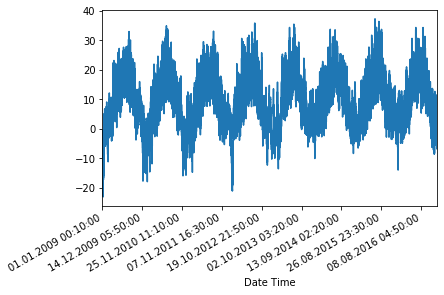

In [9]:

plot_df = df['T (degC)']
plot_df.index = df['Date Time']
plot_df.plot(subplots=True)


## To Do: What's KDE Plot

In [ ]:
# What's kde plot???
plot_df.plot(kind='kde')

# Extracting Temperature to a Dataframe

In [10]:
df_s = pd.DataFrame({'Date Time':plot_df.index, 'Temperature':plot_df.values})
df_s['Date Time'] = pd.to_datetime(df_s['Date Time'])
df_s = df_s.set_index('Date Time')
df_s.head(100)

,Temperature
Date Time,
2009-01-01 00:10:00,-8.02
2009-01-01 00:20:00,-8.41
2009-01-01 00:30:00,-8.51
2009-01-01 00:40:00,-8.31
2009-01-01 00:50:00,-8.27
...,...
2009-01-01 16:00:00,-5.40
2009-01-01 16:10:00,-5.31
2009-01-01 16:20:00,-5.28


# Decomposition of timeseries into Trend, Seasonality and Residuals

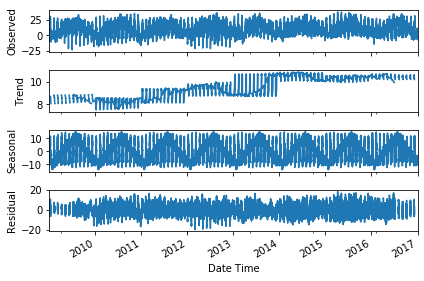

In [11]:
# Need to write frequency calculation
result = seasonal_decompose(df_s, freq=52560)
result.plot()
plt.show()

# Histogram Plot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5204173f10>]],
      dtype=object)

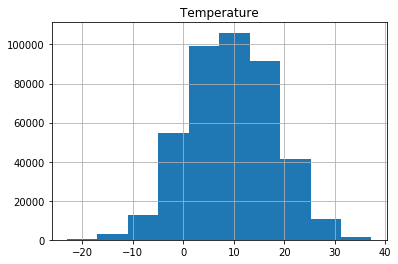

In [12]:
df_s.hist()

# Check if Time Series is Stationary

In [ ]:
def test_stationarity(df_s):
    X = df_s.values
    split = int(len(X) / 2)
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    return [{'Mean-1': mean1,'Mean-2': mean2}, {'Variance-1':var1,'Variance-2':var2}]
    

In [ ]:
results = test_stationarity(df_s)
print("Simple Results:")
print("Mean for first 1/2 of data: {}, Mean for Second 1/2 of data: {}".
      format(results[0].get('Mean-1'), results[0].get('Mean-2')))
print("Variance for first 1/2 of data: {}, Mean for Second 1/2 of data: {}".
      format(results[1].get('Variance-1'), results[1].get('Variance-2')))

# Dickey Fuller test for stationarity check

#### Todo: Actually the P value is less than 0.05 implies we can reject null hypothesis and consider that timeseries is stationary. Here timeseries is not stationary but p value is less than 0.05. Don't know why!!

# Dickey Fuller test using statstools function

In [ ]:
#define function for ADF test
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,maxlag =1)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


In [ ]:
data = df_s['Temperature']
data = data.values.flatten()
adf_test(data)

# Dickey Fuller test by writing the function from scratch

In [ ]:
import numpy as np
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.tsatools import lagmat, add_trend
from statsmodels.tsa.adfvalues import mackinnonp

def adf(ts):
    """
    Augmented Dickey-Fuller unit root test
    """
    # make sure we are working with an array, convert if necessary
    ts = np.asarray(ts)
    
    # Get the dimension of the array
    nobs = ts.shape[0]
    
    # We use 1 as maximum lag in our calculations
    maxlag = 1
    
    # Calculate the discrete difference
    tsdiff = np.diff(ts)
    
    # Create a 2d array of lags, trim invalid observations on both sides
    tsdall = lagmat(tsdiff[:, None], maxlag, trim='both', original='in')
    # Get dimension of the array
    nobs = tsdall.shape[0] 
    
    # replace 0 xdiff with level of x
    tsdall[:, 0] = ts[-nobs - 1:-1]  
    tsdshort = tsdiff[-nobs:]
    
    # Calculate the linear regression using an ordinary least squares model    
    results = OLS(tsdshort, add_trend(tsdall[:, :maxlag + 1], 'c')).fit()
    adfstat = results.tvalues[0]
    
    # Get approx p-value from a precomputed table (from stattools)
    pvalue = mackinnonp(adfstat, 'c', N=1)
    return pvalue

In [ ]:
adf(df_s['Temperature'])

# Removing Non Stationarity

In [ ]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [ ]:
def difference_using_shift(dataset,interval):
    return dataset - dataset.shift(interval)
    

In [ ]:
def perform_seasonal_decomposition(series_data):
    series_data = series_data.dropna()
    df_s = pd.DataFrame({'Date Time':series_data.index, 'Temperature':series_data.values})
    df_s['Date Time'] = pd.to_datetime(df_s['Date Time'])
    df_s = df_s.set_index('Date Time')
    result = seasonal_decompose(df_s, freq=52560)
    result.plot()
    plt.show()

In [ ]:
# It's taking a long time for somereason
plot_df = difference(df['T (degC)'])
plot_df.index = df['Date Time'].values[1:]
perform_seasonal_decomposition(plot_df)

# Using Differencing

In [ ]:
plot_df = difference_using_shift(df['T (degC)'],1)
plot_df.index = df['Date Time']
perform_seasonal_decomposition(plot_df)
print(plot_df.shape)

# 30 days Data

In [ ]:
# Why 4320?
# 6 observations per hour. 24 hours per day => 24*6 = 144 observations per day => 144*30 per 30 days => 4320
day_30_data = plot_df.iloc[1:4320]

In [ ]:
TRAIN_SPLIT = 4316

In [ ]:
train, test = day_30_data[1:TRAIN_SPLIT+1], day_30_data[TRAIN_SPLIT:]

# AR Model

In [ ]:
from statsmodels.tsa.ar_model import AR
model = AR(train.values)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start = len(train), end = len(train)+len(test)-1)
print('Predictions:')
print('-----------------')
print(predictions)
print(test)

In [ ]:
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot results

# MA Model

In [ ]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(train.values, order=(0, 1))
model_fit = model.fit(disp=False)
predictions = model_fit.predict(start = len(train), end = len(train)+len(test)-1)
print('Predictions:')
print('-----------------')
print(predictions)

In [ ]:
model_fit.summary()

# Data visualisation using AR and MA models

In [ ]:
# One year of data => 365*144 => 52560 nearly
temp_df = plot_df[1: 52557]

In [ ]:
def plot_data(results):
    df_t = pd.DataFrame({'index':pd.to_datetime(temp_df.index).strftime('%d-%m-%Y'),'Actual temp':temp_df})
    df_p = pd.DataFrame({'index':pd.to_datetime(results.fittedvalues.index).strftime('%d-%m-%Y'),'Predicted temp':results.fittedvalues})
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    df_t.plot(y=["Actual temp"], ax=ax,color='blue')
    df_p.plot(y=["Predicted temp"], ax=ax2, ls="--",color='red')


    ax.legend(loc=1)
    ax2.legend(loc=2)
    fig.autofmt_xdate()
    plt.show()

In [ ]:
model = ARIMA(temp_df,order=(0,1,2))
results_ma = model.fit(disp=-1)
temp_df = temp_df[1:len(temp_df)]
# Residual sum of squares
print('Residual Sum of squares: {}'.format(sum((results_ma.fittedvalues-temp_df)**2)))

In [ ]:
plot_data(results_ma)

In [ ]:
model = ARIMA(temp_df,order=(2,1,0))
results_ar = model.fit(disp=-1)
temp_rss = (results_ar.fittedvalues-temp_df).dropna()

print('Residual Sum of squares: {}'.format(sum(temp_rss**2)))
plot_data(results_ar)

# ARIMA Model

## Step-1: Find the 'd' parameter- Order of differencing

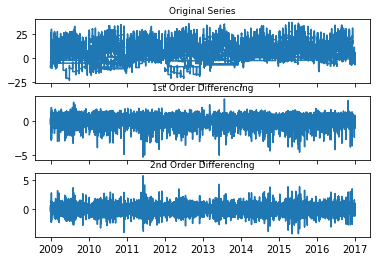

In [10]:
# Original Series
fig, axes = plt.subplots(3, 1, sharex=True)
axes[0].plot(df_s.Temperature); axes[0].set_title('Original Series',fontsize=9)
# 1st Differencing
axes[1].plot(df_s.Temperature.diff()); axes[1].set_title('1st Order Differencing',fontsize=9)
# 2nd Differencing
axes[2].plot(df_s.Temperature.diff().diff()); axes[2].set_title('2nd Order Differencing',fontsize=9)
plt.show()

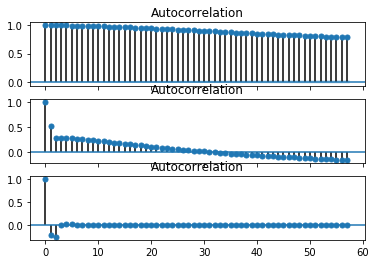

In [11]:
fig, axes = plt.subplots(3, 1, sharex=True)
plot_acf(df_s.Temperature, ax=axes[0])
plot_acf(df_s.Temperature.diff().dropna(), ax=axes[1])
plot_acf(df_s.Temperature.diff().diff().dropna(), ax=axes[2])
plt.show()

## Finding the order of AR term

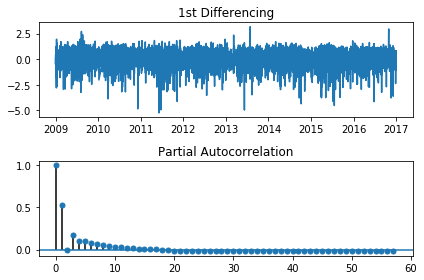

In [27]:
fig, axes = plt.subplots(2, 1)
axes[0].plot(df_s.Temperature.diff()); axes[0].set_title('1st Differencing')
plot_pacf(df_s.Temperature.diff().dropna(), alpha = 0.05, ax=axes[1])
plt.tight_layout()
plt.show()

# Finding the order of MA term

Just like we used PACF for finding the order of AR term, for MA term we use ACF Plot. 
Basically for MA term we need to know how many lagged terms need to be incoporated in the model- which ACF plot clearly shows

In [15]:
model = ARIMA(df_s.Temperature, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.Temperature   No. Observations:               420550
Model:                 ARIMA(1, 1, 1)   Log Likelihood               58865.299
Method:                       css-mle   S.D. of innovations              0.210
Date:                Sat, 25 Jan 2020   AIC                        -117722.597
Time:                        16:42:43   BIC                        -117678.800
Sample:                             1   HQIC                       -117710.109
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                5.102e-06      0.001      0.008      0.994      -0.001       0.001
ar.L1.D.Temperature     0.5048      0.004    135.603      0.000       0.498       0.512
ma.L1.D.Temperat

In [18]:
from statsmodels.tsa.arima_model import ARIMA

# 2,1,2 ARIMA Model
model = ARIMA(df_s.Temperature, order=(2,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.Temperature   No. Observations:               420550
Model:                 ARIMA(2, 1, 2)   Log Likelihood               72823.674
Method:                       css-mle   S.D. of innovations              0.203
Date:                Sat, 25 Jan 2020   AIC                        -145635.348
Time:                        16:51:55   BIC                        -145569.652
Sample:                             1   HQIC                       -145616.615
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -2.547e-06      0.001     -0.002      0.999      -0.003       0.003
ar.L1.D.Temperature     0.8968      0.005    195.245      0.000       0.888       0.906
ar.L2.D.Temperat

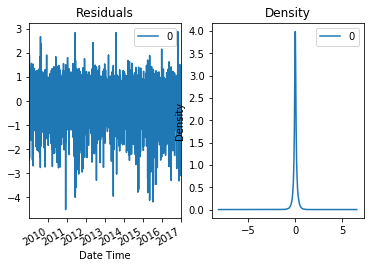

In [19]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

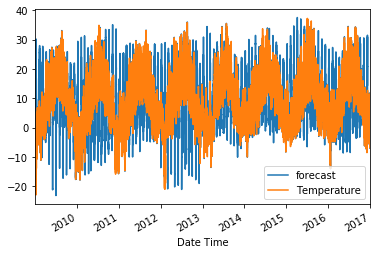

In [20]:
model_fit.plot_predict(dynamic=False)
plt.show()